# Применение моделей глубинного обучения

## Импорты, загрузка данных

In [ ]:
# Импорты
import pandas as pd
from collections import Counter
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss
import gdown
import numpy as np
import torch
import torch.nn as nn
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from torch.utils.data import TensorDataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import ml_utils as mu

### Загрузка данных

In [ ]:
# Сэмпл датасета (10%) для подбора оптимальной модели
sample_10_id = '17IVd8t37FZ-WULTMCnsUv8vbd6PuzeKx'
gdown.download(f"https://drive.google.com/uc?id={sample_10_id}", quiet=True)

# 50% датасета (которые поместились в 32гб оперативки)
df_50_id = '12mIlvk7Fb7yfdvoml7dmE-8TuGLh4c-V'
gdown.download(f"https://drive.google.com/uc?id={df_50_id}", quiet=True)

# Если понадобится - полный датасет (400к статей)
# df_100_id = '1YvQ2kxQqq1JJBfzTqygftj_RMOnV0ZTd'
# gdown.download(f"https://drive.google.com/uc?id={df_100_id}", quiet=False)

In [ ]:
df = pd.read_parquet("df_final_50.parquet")

In [3]:
df.head(2)

,author,publication_date,hubs,comments,views,url,reading_time,individ/company,bookmarks_cnt,text_length,rating_new,text_pos_tags,tags_tokens,title_tokens,text_tokens
0,LivingDead,2011-09-13 14:45:04+00:00,Разработка игр,16,34000,https://habr.com/ru/articles/128368/,2.0,individual,78.0,2677,21.0,"[PRON, ADJ, NOUN, NOUN, PRON, VERB, AUX, VERB,...","[minecraft, noise, perlin, d, landscape]","[генерация, ландшафт, minecraft]","[добрый, время, суток, поделиться, личный, опы..."
1,AlfaTeam,2022-09-07 12:19:42+00:00,"Блог компании Альфа-Банк, JavaScript, Программ...",13,19000,https://habr.com/ru/companies/alfa/articles/68...,8.0,company,44.0,12132,18.0,"[PRON, VERB, ADP, ADJ, NOUN, PROPN, PRON, VERB...","[react, react, router, react, reactrouter, мар...","[переходить, reactrouter, v, подводный, камень...","[перейти, шестой, версия, reactrouter, помочь,..."


In [4]:
# Выделение рейтинга статьи
df['rating_level'] = mu.categorize_ratings(df)

# Предобработка датасета: фильтрация, объединение текстовых токенов,
# кодировка меток(хабов) и преобразование рейтингов
(df_prepr, y_multi_reduced, selector, 
index_to_label, mlb, 
y_rating, inverse_rating_mapping, indices) = mu.df_preprocess(df)

## Полносвязная модель

### Предобработка данных

In [5]:
# Оставим только необходимые столбцы
X = df_prepr[['text_combined']].copy()
text_col = 'text_combined'

# Выделям матрицы признаков признаков для хабов и рейтинга
X_hubs = X.iloc[indices].copy()
X_rating = X.copy()

# Разделение на обучающую и тестовую выборки для предсказания хабов (тем) статей
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_hubs, y_multi_reduced, test_size=0.25)

# Разделение на обучающую и тестовую выборки для предсказания рейтинга статьи
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_rating, y_rating, test_size=0.25)

In [6]:
# Пайплайн для предобработки текстовых данных
text_pipe= Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('svd', TruncatedSVD(n_components=50, random_state=42))])

# Хабы
X_train_h_pipe = text_pipe.fit_transform(X_train_h['text_combined'])
X_test_h_pipe = text_pipe.transform(X_test_h['text_combined'])

# Рейтинг
X_train_r_pipe = text_pipe.fit_transform(X_train_r['text_combined'])
X_test_r_pipe = text_pipe.transform(X_test_r['text_combined'])

In [7]:
# Количество классов
n_classes_h = len(y_train_h[0])
n_classes_r = len(set(y_train_r))

# DataLoader
batch_size = 64
def make_loader(X, y, task_type, shuffle=True):
    X_t = torch.from_numpy(X).float()
    if task_type == 'hubs':
        y_t = torch.from_numpy(np.array(y)).float()
    elif task_type == 'rating':
        y_t = torch.from_numpy(np.array(y)).long()
    ds = TensorDataset(X_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

# loader для хабов
train_loader_h = make_loader(X_train_h_pipe, y_train_h, task_type='hubs', shuffle=True)
test_loader_h  = make_loader(X_test_h_pipe, y_test_h, task_type='hubs',  shuffle=False)

# loader для рейтинга
train_loader_r = make_loader(X_train_r_pipe, y_train_r, task_type='rating', shuffle=True)
test_loader_r  = make_loader(X_test_r_pipe,  y_test_r, task_type='rating',  shuffle=False)

### Архитектура нейросети, обучение

In [8]:
# Архитектура полносвязной модели
class FCNet(nn.Module):
    def __init__(self, input_size, hidden_size, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, n_classes)
        )

    def forward(self, x):
        pred = self.net(x)
        return pred

# Перевод вычислений на GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# Задаём все переменные для предсказания хабов
fcnet_h = FCNet(input_size = X_train_h_pipe.shape[1],
                hidden_size = 256,
                n_classes = n_classes_h).to(device)
optimizer_h = torch.optim.Adam(fcnet_h.parameters(), lr=1e-3)

# Задаём все переменные для предсказания рейтинга
fcnet_r = FCNet(input_size = X_train_r_pipe.shape[1],
                hidden_size = 256,
                n_classes = n_classes_r).to(device)

optimizer_r = torch.optim.Adam(fcnet_r.parameters(), lr=1e-3)

In [22]:
# Функция для оценки модели на тестовой выборке
# Возвращает loss, f1-score по эпохам
def test(model, loader, criterion, model_type):
    loss_log = []
    all_preds = []
    all_targets = []
    model.eval()

    if model_type == 'fc':
        for data, target in loader:
            data, target = data.to(device), target.to(device)

            # forward
            with torch.no_grad():
                y_pred = model(data)
            loss = criterion(y_pred, target)
            loss_log.append(loss.item())

            # predict
            if isinstance(criterion, nn.BCEWithLogitsLoss):
                pred_probs = torch.sigmoid(y_pred)
                pred_classes = (pred_probs > 0.5).float().cpu().numpy()
            elif isinstance(criterion, nn.CrossEntropyLoss):
                pred_classes = y_pred.argmax(dim=-1).cpu().numpy()

            target_np = target.cpu().numpy()
            all_preds.append(pred_classes)
            all_targets.append(target_np)
    
    elif model_type == 'rnn':
        for tabular, text, target in loader:
            tabular, text, target = tabular.to(device), text.to(device), target.to(device)

            # forward
            with torch.no_grad():
                y_pred = model(tabular, text)
            loss = criterion(y_pred, target)
            loss_log.append(loss.item())

            # predict
            if isinstance(criterion, nn.BCEWithLogitsLoss):
                pred_probs = torch.sigmoid(y_pred)
                pred_classes = (pred_probs > 0.5).float().cpu().numpy()
            elif isinstance(criterion, nn.CrossEntropyLoss):
                pred_classes = y_pred.argmax(dim=-1).cpu().numpy()

            target_np = target.cpu().numpy()
            all_preds.append(pred_classes)
            all_targets.append(target_np)

    # Объединяем предсказания и метки
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    # Считаем метрики
    f1 = f1_score(all_targets, all_preds, average='micro')
    precision = precision_score(all_targets, all_preds, average='micro', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='micro', zero_division=0)
    hamming = hamming_loss(all_targets, all_preds)

    return np.mean(loss_log), f1, precision, recall, hamming

# Функция обучения модели в течение 1 эпохи
# Возвращает loss и f1-score по батчам
def train_epoch(model, optimizer, train_loader, criterion, model_type):
    loss_log = []
    f1_log = []
    model.train()

    if model_type == 'fc':
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            # zero gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            y_pred = model(data)
            loss = criterion(y_pred, target)
            loss.backward()
            optimizer.step()
        
            # Метрики
            if isinstance(criterion, nn.BCEWithLogitsLoss):
                pred_probs = torch.sigmoid(y_pred)
                pred_classes = (pred_probs > 0.5).float().cpu().numpy()
            elif isinstance(criterion, nn.CrossEntropyLoss):
                pred_classes = y_pred.argmax(dim=-1).cpu().numpy()

            target_np = target.cpu().numpy()
            f1 = f1_score(target_np, pred_classes, average='micro')
            loss_log.append(loss.item())
            f1_log.append(f1)

    elif model_type == 'rnn':
        for tabular, text, target in train_loader:
            tabular, text, target = tabular.to(device), text.to(device), target.to(device)

            # zero gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            y_pred = model(tabular, text)
            loss = criterion(y_pred, target)
            loss.backward()
            optimizer.step()
        
            # Метрики
            if isinstance(criterion, nn.BCEWithLogitsLoss):
                pred_probs = torch.sigmoid(y_pred)
                pred_classes = (pred_probs > 0.5).float().cpu().numpy()
            elif isinstance(criterion, nn.CrossEntropyLoss):
                pred_classes = y_pred.argmax(dim=-1).cpu().numpy()

            target_np = target.cpu().numpy()
            f1 = f1_score(target_np, pred_classes, average='micro')
            loss_log.append(loss.item())
            f1_log.append(f1)

    return loss_log, f1_log

In [ ]:
# Общая функция для обучения/теста модели
def train(model, optimizer, n_epochs, train_loader, test_loader,
          train_epoch, test_func, task_type, criterion, model_type):
    # логи по батчам
    train_loss_all, train_f1_all = [], []
    # логи по эпохам
    test_loss_log, test_f1_log = [], []
    test_prec_log, test_rec_log, test_ham_log = [], [], []

    steps_per_epoch = len(train_loader)

    for epoch in range(n_epochs):
        # train_epoch теперь возвращает списки по батчам
        batch_losses, batch_f1s = train_epoch(model, optimizer, train_loader, criterion, model_type)
        train_loss_all.extend(batch_losses)
        train_f1_all.extend(batch_f1s)

        # валидируем раз в эпоху
        test_loss, test_f1, test_prec, test_rec, test_ham = test_func(model, test_loader, criterion, model_type)
        test_loss_log.append(test_loss)
        test_f1_log.append(test_f1)
        test_prec_log.append(test_prec)
        test_rec_log.append(test_rec)
        test_ham_log.append(test_ham)

        # выводим раз в 5 эпох
        if epoch % 5 == 0:
            print(f"Epoch {epoch}")
            print(f" train loss: {np.mean(batch_losses):.4f}, train f1: {np.mean(batch_f1s):.4f}")

            if task_type == 'hubs':
                print(f" test loss: {np.mean(test_loss):.4f}, test f1: {test_f1:.4f}, test precision: {test_prec:.4f}, test recall: {test_rec:.4f}, test hamming: {test_ham:.4f}\n")
            elif task_type == 'rating':
                print(f" test loss: {test_loss:.4f}, test f1: {test_f1:.4f}, test hamming: {test_ham:.4f}\n")

    return (train_loss_all, train_f1_all,
            test_loss_log, test_f1_log,
            test_prec_log, test_rec_log, test_ham_log,
            steps_per_epoch)

In [ ]:
# Обучаем модель хабов
(train_loss_log, train_f1_log, test_loss_log, test_f1_log, 
 test_prec_log, test_rec_log, test_ham_log, steps_per_epoch) = train(
    fcnet_h, optimizer_h, 51, train_loader_h, 
    test_loader_h, train_epoch, test, 
    task_type='hubs', criterion=nn.BCEWithLogitsLoss(), model_type='fc')

Epoch 0
 train loss: 0.1030, train f1: 0.1507
 test loss: 0.0730, test f1: 0.3065, test precision: 0.6921, test recall: 0.1968, test hamming: 0.0237

Epoch 5
 train loss: 0.0647, train f1: 0.4302
 test loss: 0.0632, test f1: 0.4560, test precision: 0.6965, test recall: 0.3389, test hamming: 0.0215

Epoch 10
 train loss: 0.0619, train f1: 0.4588
 test loss: 0.0610, test f1: 0.4660, test precision: 0.7119, test recall: 0.3464, test hamming: 0.0211

Epoch 15
 train loss: 0.0605, train f1: 0.4734
 test loss: 0.0600, test f1: 0.4832, test precision: 0.7092, test recall: 0.3665, test hamming: 0.0209

Epoch 20
 train loss: 0.0596, train f1: 0.4814
 test loss: 0.0594, test f1: 0.4895, test precision: 0.7084, test recall: 0.3739, test hamming: 0.0208

Epoch 25
 train loss: 0.0589, train f1: 0.4888
 test loss: 0.0591, test f1: 0.4921, test precision: 0.7103, test recall: 0.3765, test hamming: 0.0207

Epoch 30
 train loss: 0.0584, train f1: 0.4923
 test loss: 0.0589, test f1: 0.4951, test precisi

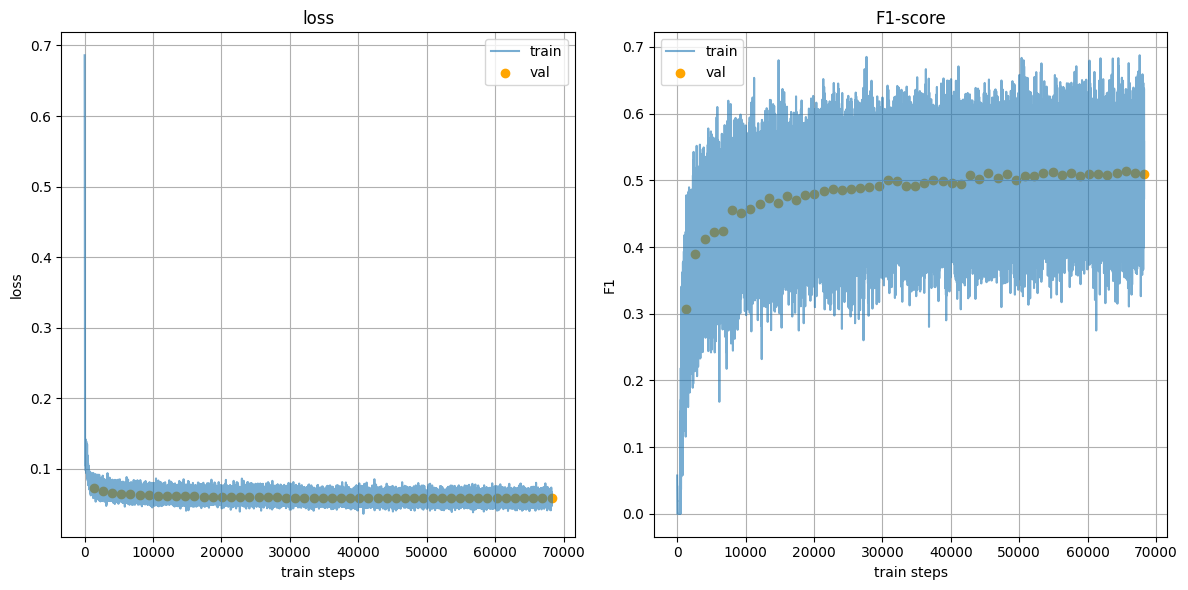

In [ ]:
# Визуализируем для хабов
mu.plot_history(train_loss_log, train_f1_log, test_loss_log, test_f1_log, 
             steps_per_epoch=steps_per_epoch,  figsize=(12,6))

`Выводы для модели хабов`
* На графике потерь видно, что на тренировочной и тестовой выборках loss снижается в начале обучения (~10 000 шагов) и стабилизируется на уровне 0.05-0.06 (довольно низкий loss), то есть модель успешно сходится и не переобучается (что видно также по близким метрикам train f1 - 0.507 и test f1 - 0.510)
* Итоговые значения на тестовой выборке f1-score (micro) 0.507, что говорит о среднем качестве предсказаний, при этом виден значительный перевес в сторону точности (precision - 0.703) в сравнении с полнотой (recall 0.399) - этот же перекос наблюдался и раньше при экспериментах с классическими ML-моделями, hamming loss довольно низкий (0.02), то есть доля ошибочно предсказанных меток мала

In [ ]:
# Обучаем модель для рейтинга
(train_loss_log, train_f1_log, test_loss_log, 
test_f1_log, test_prec_log, test_rec_log, 
test_ham_log, steps_per_epoch) = train(
    fcnet_r, optimizer_r, 21, train_loader_r, 
    test_loader_r, train_epoch, test, 
    task_type='rating', criterion=nn.CrossEntropyLoss(), model_type='fc')

Epoch 0
 train loss: 1.1526, train f1: 0.4608
 test loss: 1.1323, test f1: 0.4726, test hamming: 0.5274

Epoch 5
 train loss: 1.1049, train f1: 0.4872
 test loss: 1.1098, test f1: 0.4846, test hamming: 0.5154

Epoch 10
 train loss: 1.0904, train f1: 0.4977
 test loss: 1.1053, test f1: 0.4882, test hamming: 0.5118

Epoch 15
 train loss: 1.0786, train f1: 0.5018
 test loss: 1.1018, test f1: 0.4899, test hamming: 0.5101

Epoch 20
 train loss: 1.0689, train f1: 0.5097
 test loss: 1.1020, test f1: 0.4936, test hamming: 0.5064



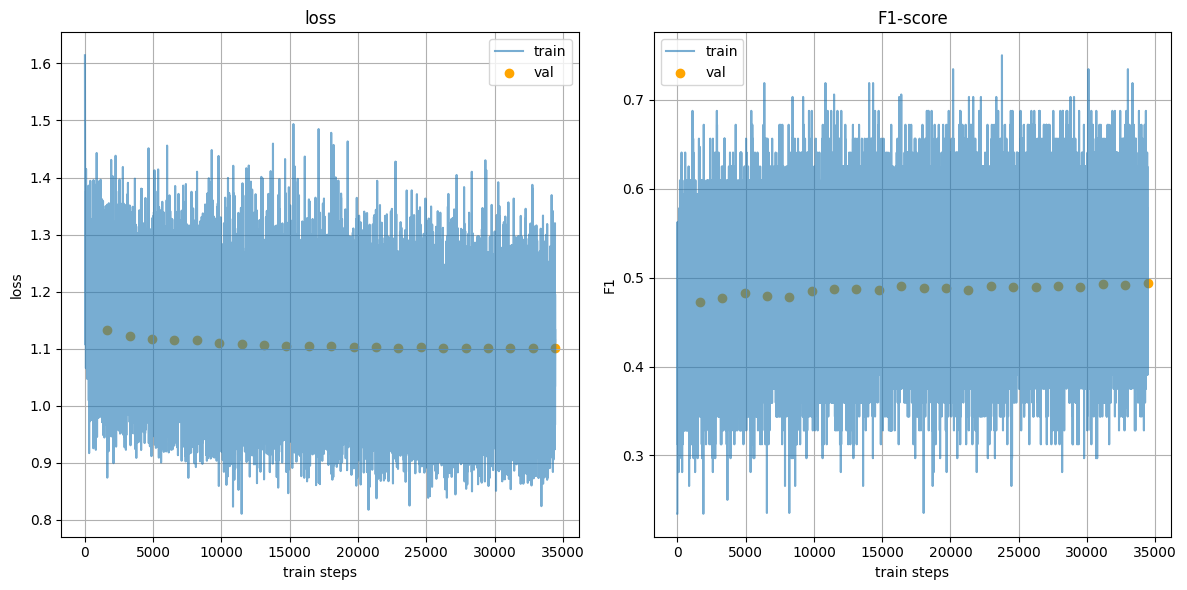

In [ ]:
# Визуализируем для рейтинга
mu.plot_history(train_loss_log, train_f1_log, test_loss_log, test_f1_log, 
             steps_per_epoch=steps_per_epoch,  figsize=(12,6))

`Выводы для модели рейтинга`
* Также можем наблюдать начало графика потерь с высокого loss, с его постепенным уменьшением по мере увеличения количества шагов, разница между train и test f1-score на последней эпохе тоже не велика (0.510 и 0.493 соответственно), сильного переобучения не наблюдается
* F1-score находится на уровне 50%, что говорит о среднем качестве получнных предсказаний для полносвязной модели, при этом hamming loss довольно высокий - 0.506, практически половина предсказанных меток ошибочны
* Что интересно - модель уже с первой эпохи выходит на приемлемые значения метрики test f1-score (0.472), тогда как для модели хабов этот процесс был более постепенным (от низких значений на первых эпохах до более высоких на поздних)

## Рекуррентная модель

### Предобработка данных

In [16]:
X = df_prepr.drop(columns=['author', 'publication_date', 'url', 'text_pos_tags', 'hubs', 'rating_level', 'rating_new', 'hubs_encoded']).copy()

# Кодировка individ/company
X['individ/company'] = X['individ/company'].map({'individual': 0, 'company': 1})
X = X.rename(columns={'individ/company':'is_company'})

# Матрица признаков
X_hubs = X.iloc[indices].copy()
X_rating = X.copy()

# Выделяем нужные столбцы
num_cols= ['comments', 'views', 'reading_time', 'bookmarks_cnt', 'text_length']

# Разделение на обучающую и тестовую выборки для предсказания хабов (тем) статей
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_hubs, y_multi_reduced, test_size=0.25)

# Разделение на обучающую и тестовую выборки для предсказания рейтинга статьи
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_rating, y_rating, test_size=0.25)

In [ ]:
# Табличные данные
X_train_h_num = X_train_h[num_cols].to_numpy()
X_test_h_num = X_test_h[num_cols].to_numpy()
X_train_r_num = X_train_r[num_cols].to_numpy()
X_test_r_num = X_test_r[num_cols].to_numpy()

# Масштабирование табличных данных
scaler_h = StandardScaler()
X_train_h_num = scaler_h.fit_transform(X_train_h_num)
X_test_h_num = scaler_h.transform(X_test_h_num)

scaler_r = StandardScaler()
X_train_r_num = scaler_r.fit_transform(X_train_r_num)
X_test_r_num = scaler_r.transform(X_test_r_num)

# Обработка текстовых данных
# Разделим TF-IDF-вектора на псевдо-последовательности (seq_len=10, 5 компонент на шаг)
seq_len = 10
svd_components = 50
components_per_step = svd_components // seq_len  # 5 компонент
X_train_h_text = X_train_h_pipe.reshape(-1, seq_len, components_per_step)
X_test_h_text= X_test_h_pipe.reshape(-1, seq_len, components_per_step)
X_train_r_text = X_train_r_pipe.reshape(-1, seq_len, components_per_step)
X_test_r_text = X_test_r_pipe.reshape(-1, seq_len, components_per_step)

In [ ]:
# DataLoader для RNN
def make_loader_rnn(X, text, y, task_type, shuffle=True):
    X_t = torch.from_numpy(X).float()
    text_t = torch.from_numpy(text).float()
    if task_type == 'hubs':
        y_t = torch.from_numpy(np.array(y)).float()
    elif task_type == 'rating':
        y_t = torch.from_numpy(np.array(y)).long()
    ds = TensorDataset(X_t, text_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)


train_loader_h = make_loader_rnn(X_train_h_num, X_train_h_text, 
                                 y_train_h, task_type='hubs', shuffle=True)
test_loader_h = make_loader_rnn(X_test_h_num, X_test_h_text, 
                                y_test_h, task_type='hubs', shuffle=False)

train_loader_r = make_loader_rnn(X_train_r_num, X_train_r_text, 
                                 y_train_r, task_type='rating', shuffle=True)
test_loader_r = make_loader_rnn(X_test_r_num, X_test_r_text, 
                                y_test_r, task_type='rating', shuffle=False)

### Архитектура нейросети, обучение

In [19]:
class RNN(nn.Module):
    def __init__(self, text_input, num_input, hidden_size, n_classes, dropout):
        super().__init__()
        # Табличные признаки
        self.tabular_net = nn.Sequential(
        nn.Linear(num_input, hidden_size),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_size, hidden_size//2),
        nn.ReLU())
        
        # Текстовые признаки
        self.gru = nn.GRU(text_input, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size//2 + hidden_size, n_classes)
    
    def forward(self, tabular, text):
        # Обработка табличных данных
        tabular_out = self.tabular_net(tabular)

        # Обработка текстовых данных
        gru_out, hn = self.gru(text)
        text_out = hn[-1]

        # Объединяем
        combined = torch.cat((tabular_out, text_out), dim=1)
        pred = self.fc(combined)
        return pred

In [ ]:
# Задаём модели
# Увеличим вес положительных меток для хабов
pos_weight = torch.ones(n_classes_h).to(device) * 3
criterion_h = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Модель хабов
rnn_h = RNN(text_input=components_per_step, num_input=len(num_cols), hidden_size=256,
            n_classes=n_classes_h, dropout=0.3).to(device)
optimizer_h = torch.optim.Adam(rnn_h.parameters(), lr=1e-3)

# Модель рейтинга
rnn_r = RNN(text_input=components_per_step, num_input=len(num_cols), hidden_size=256,
            n_classes=n_classes_r, dropout=0.2).to(device)
optimizer_r = torch.optim.Adam(rnn_r.parameters(), lr=1e-3)

In [21]:
# Обучаем модель хабов
(train_loss_log, train_f1_log, test_loss_log, 
test_f1_log, test_prec_log, test_rec_log, 
test_ham_log, steps_per_epoch) = train(
    rnn_h, optimizer_h, 51, train_loader_h, 
    test_loader_h, train_epoch, test, 
    task_type='hubs', criterion=criterion_h, model_type='rnn')

Epoch 0
 train loss: 0.2470, train f1: 0.1152
 test loss: 0.2359, test f1: 0.1256, test precision: 0.4896, test recall: 0.0720, test hamming: 0.0267

Epoch 5
 train loss: 0.2307, train f1: 0.1341
 test loss: 0.2302, test f1: 0.1351, test precision: 0.5024, test recall: 0.0780, test hamming: 0.0266

Epoch 10
 train loss: 0.2288, train f1: 0.1387
 test loss: 0.2294, test f1: 0.1325, test precision: 0.5207, test recall: 0.0759, test hamming: 0.0264

Epoch 15
 train loss: 0.2277, train f1: 0.1419
 test loss: 0.2289, test f1: 0.1359, test precision: 0.5063, test recall: 0.0785, test hamming: 0.0265

Epoch 20
 train loss: 0.2269, train f1: 0.1435
 test loss: 0.2290, test f1: 0.1388, test precision: 0.4922, test recall: 0.0808, test hamming: 0.0266

Epoch 25
 train loss: 0.2260, train f1: 0.1461
 test loss: 0.2292, test f1: 0.1396, test precision: 0.4717, test recall: 0.0819, test hamming: 0.0268

Epoch 30
 train loss: 0.2248, train f1: 0.1489
 test loss: 0.2300, test f1: 0.1407, test precisi

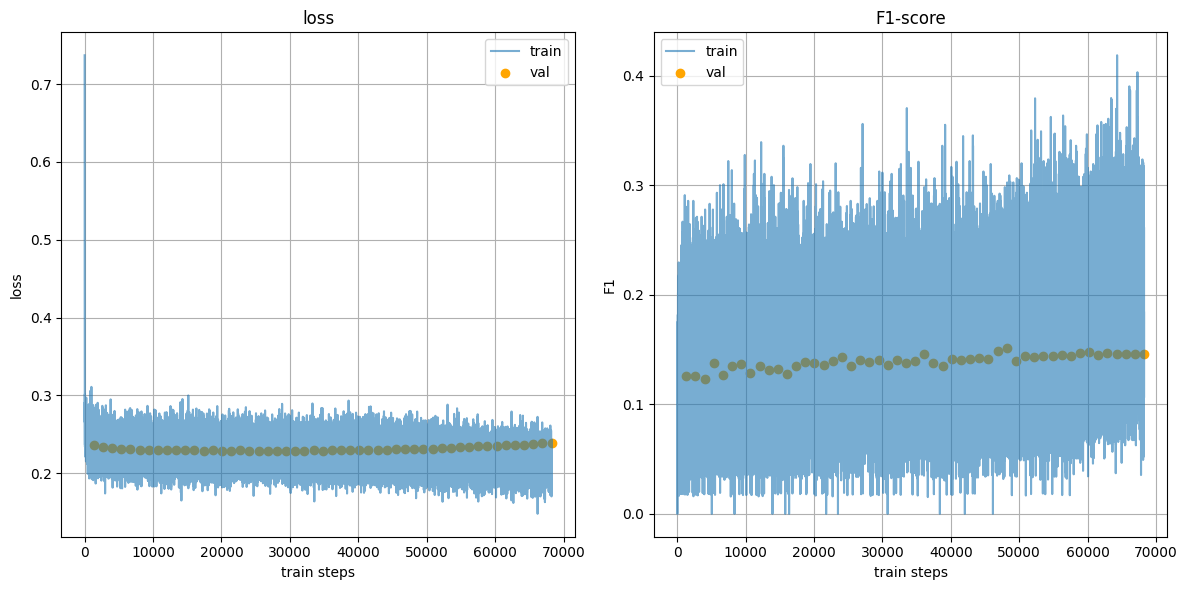

In [23]:
# Визуализируем для хабов
mu.plot_history(train_loss_log, train_f1_log, test_loss_log, test_f1_log, 
             steps_per_epoch=steps_per_epoch,  figsize=(12,6))

`Выводы для хабов`
* RNN-модель показала более плохую предсказательную способность в сравнении с полносвязной моделью - test f1-score снизился до непозволительных значений в 0.146 (в сравнении с 0.509 у полносвязной)
* Также разница между train и test f1-score (0.198 и 0.146) указывает на рост переобучения модели
* Такое поведение модели может быть связано с видом предобработки текстовых данных (SVD + TF-IDF, деленный на псевдо-последовательности), такой метод может быть недостаточно мощным для захвата сложных семантических связей в текстах (особенно в задаче классификации тем статей)

In [24]:
# Обучаем модель рейтинга
(train_loss_log, train_f1_log, test_loss_log, 
test_f1_log, test_prec_log, test_rec_log, 
test_ham_log, steps_per_epoch) = train(
    rnn_r, optimizer_r, 21, train_loader_r, 
    test_loader_r, train_epoch, test, 
    task_type='rating', criterion=nn.CrossEntropyLoss(), model_type='rnn')

Epoch 0
 train loss: 0.9644, train f1: 0.5819
 test loss: 0.9449, test f1: 0.5856, test hamming: 0.4144

Epoch 5
 train loss: 0.9264, train f1: 0.6000
 test loss: 0.9272, test f1: 0.5974, test hamming: 0.4026

Epoch 10
 train loss: 0.9200, train f1: 0.6024
 test loss: 0.9202, test f1: 0.6015, test hamming: 0.3985

Epoch 15
 train loss: 0.9163, train f1: 0.6046
 test loss: 0.9165, test f1: 0.6010, test hamming: 0.3990

Epoch 20
 train loss: 0.9147, train f1: 0.6041
 test loss: 0.9162, test f1: 0.6024, test hamming: 0.3976



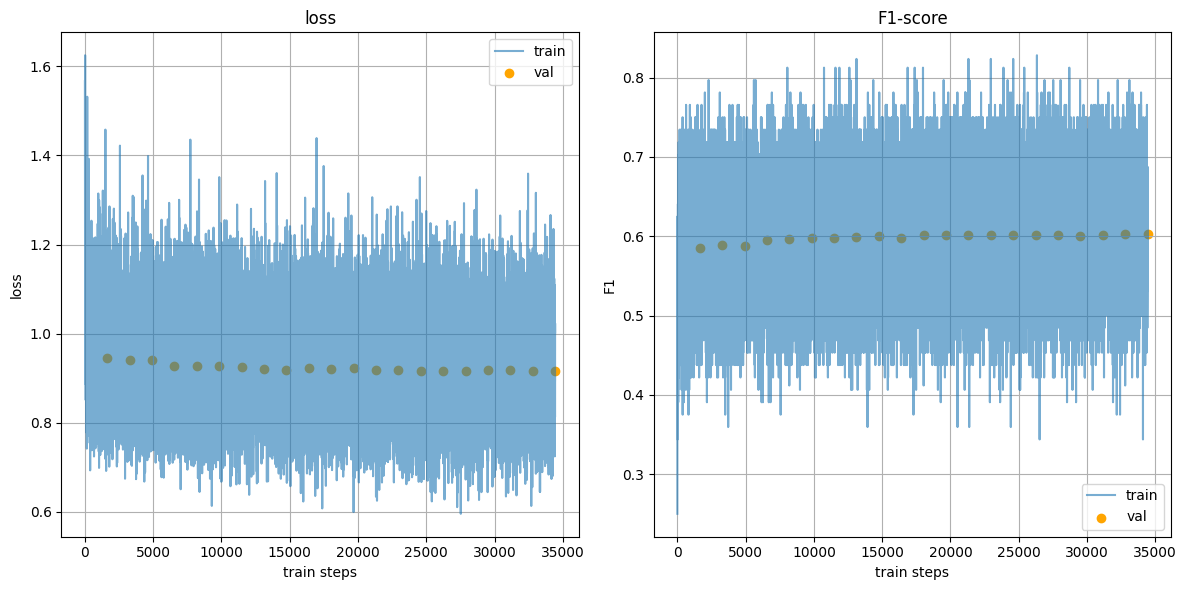

In [25]:
# Визуализируем для рейтинга
mu.plot_history(train_loss_log, train_f1_log, test_loss_log, test_f1_log, 
             steps_per_epoch=steps_per_epoch,  figsize=(12,6))

`Выводы для модели рейтинга`
* По сравнению с полносвязной моделью RNN показывает прирост практически в 10% по метрике test f1-score (0.493 против 0.602), hamming loss при этом тоже снизился (с 0.506 до 0.3976)

## Итоговые выводы

* Среди DL-моделей для предсказаний тем статей лучшие микро-метрики показала полносвязная модель (test f1: 0.5095, test precision: 0.7032, test recall: 0.3994, test hamming: 0.0205), а для предсказаний рейтинга RNN-модель с микро-метриками (test f1: 0.6024, test hamming: 0.3976)
* По сравнению с нелинейными моделями - DL-модели показывают небольшое отставание (~5% в обоих задачах), в случае тем статей лучшие микро-метрики для модели CatBoostClassifier (test precision: 0.7591, test recall: 0.4352, test f1: 0.5532, test hamming: 0.0187), а для модели рейтинга RandomForestClassifier (test f1: 0.6526, test hamming: 0.3474)
* Таким образом, итоговыми лучшими моделями для задач нашего проекта остаются нелинейные модели из предыдущего этапа (их и применим на следующем этапе обновления сервиса)